<b>Prognozy opracowane na podstawie miesięcznych wskaźników cen towarów i usług konsumpcyjnych od 2000. \
Wynik obliczony za pomocą modelu SARIMAX.</b>

In [28]:
import pandas as pd
import numpy as np

<h3>Przygotowanie danych</h3>

In [29]:
data_m = pd.read_excel("miesieczne_od_1982_roku.xlsx")

In [30]:
data_m = data_m[data_m['Sposób prezentacji'] == 'Analogiczny miesiąc poprzedniego roku = 100']
data_m = data_m[['Rok','Miesiąc','Wartość']]
data_m = data_m.dropna()
data_m = data_m[data_m.Rok > 2000]

In [31]:
data_m

,Rok,Miesiąc,Wartość
24,2023,1,116.6
25,2023,2,118.4
26,2023,3,116.1
27,2023,4,114.7
84,2022,1,109.4
...,...,...,...
1195,2001,8,105.1
1196,2001,9,104.3
1197,2001,10,104.0
1198,2001,11,103.6


In [32]:
data_m.describe()

,Rok,Miesiąc,Wartość
count,268.000000,268.000000,268.000000
mean,2011.671642,6.440299,103.099254
std,6.461382,3.469527,3.555478
min,2001.000000,1.000000,98.400000
25%,2006.000000,3.000000,101.100000
50%,2012.000000,6.000000,102.450000
75%,2017.000000,9.000000,104.000000
max,2023.000000,12.000000,118.400000


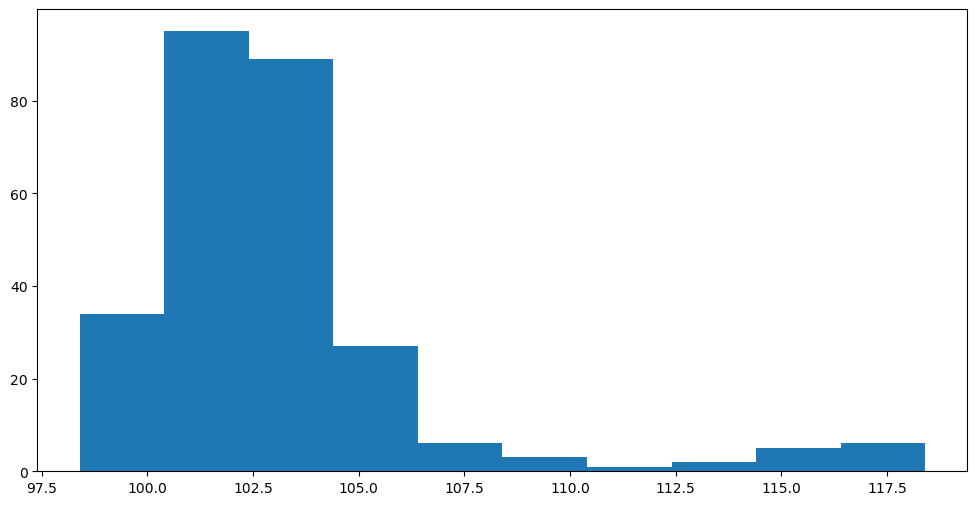

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.hist(data_m['Wartość'])
plt.show()

In [34]:
#zmiana formatu daty
from datetime import datetime
data_m['Data'] = data_m.apply(lambda row: datetime.strptime(f"{int(row.Rok)}/{int(row.Miesiąc)}/{int(1)}", '%Y/%m/%d'), axis=1)

In [35]:
data_m = data_m[['Data', 'Wartość']]

In [36]:
data_m = pd.DataFrame(data_m)
data_m = data_m.sort_values(by=['Data'])

In [37]:
data_m = data_m.set_index(['Data'])

<b>Wizualizacja inflacji w latach 2000-2023</b>

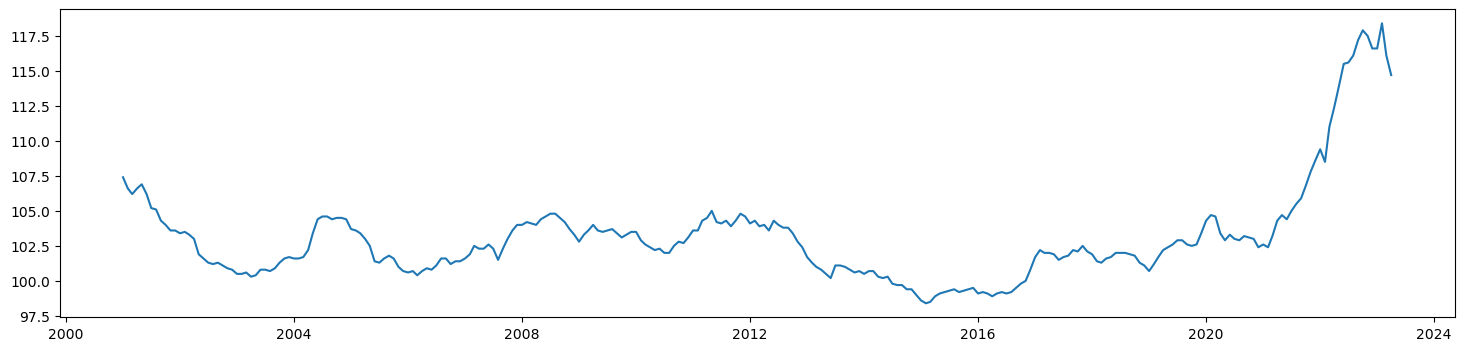

In [38]:
plt.figure(figsize=(18,4))
plt.plot(data_m['Wartość'])
plt.show()

<h3>Tworzenie modelu</h3>

<b>Szeregi czasowe są stacjonarne, jeśli nie mają trendu lub efektów sezonowych, inne są uważane za niestacjonarne.\
Dla niestacjonarnych szeregów czasowych najlepiej pasuje model SARIMAX.</b>

In [39]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(data_m.Wartość)

Test Statistic                  -1.633857
p-value                          0.465472
#Lags Used                      13.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64

<b>Ponieważ p-value jest większe niż 0.05, mamy do czynienia z niestacjonarnymi szeregami czasowymi.</b>

In [13]:
#pip install pmdarima

<b>Za pomocą AUTO ARIMA automatycznie wybieramy najlepsze parametry do modelu.</b>

In [14]:
from pmdarima.arima import auto_arima

results = auto_arima(data_m, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=587.184, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=489.211, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=573.123, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=421.271, Time=0.33 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=355.001, Time=1.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=354.746, Time=1.52 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=355.982, Time=1.94 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=390.684, Time=1.03 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=348.888, Time=2.05 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=350.371, Time=2.21 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, T

In [40]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(data_m,
                                order=(1, 1, 1),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

C:\Users\Klaudia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Klaudia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<b>Testujemy model na danych od 2016.</b>

In [41]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [42]:
pred_ci['Przewidywana'] = (pred_ci['lower Wartość'] + pred_ci['upper Wartość'])/2
pred_ci['Zaobserwowana'] = data_m['Wartość']
pred_ci['Diff, %%'] = ((pred_ci['Przewidywana'] / pred_ci['Zaobserwowana'])-1) * 100
pred_ci.tail(5)

,lower Wartość,upper Wartość,Przewidywana,Zaobserwowana,"Diff, %%"
2022-12-01,117.098361,118.761501,117.929931,116.6,1.140593
2023-01-01,115.331902,116.995042,116.163472,116.6,-0.374381
2023-02-01,116.862605,118.525345,117.693975,118.4,-0.596305
2023-03-01,116.323800,117.986333,117.155066,116.1,0.908756
2023-04-01,114.237538,115.899966,115.068752,114.7,0.321493


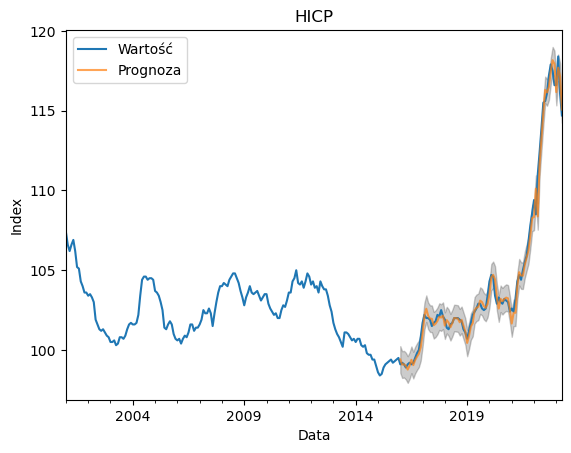

In [43]:
ax = data_m['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Prognoza', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Data')
plt.ylabel('Index')
plt.title("HICP")
plt.legend()
plt.show()

<b>Prognoza 3 lata w przód.</b>

In [44]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()

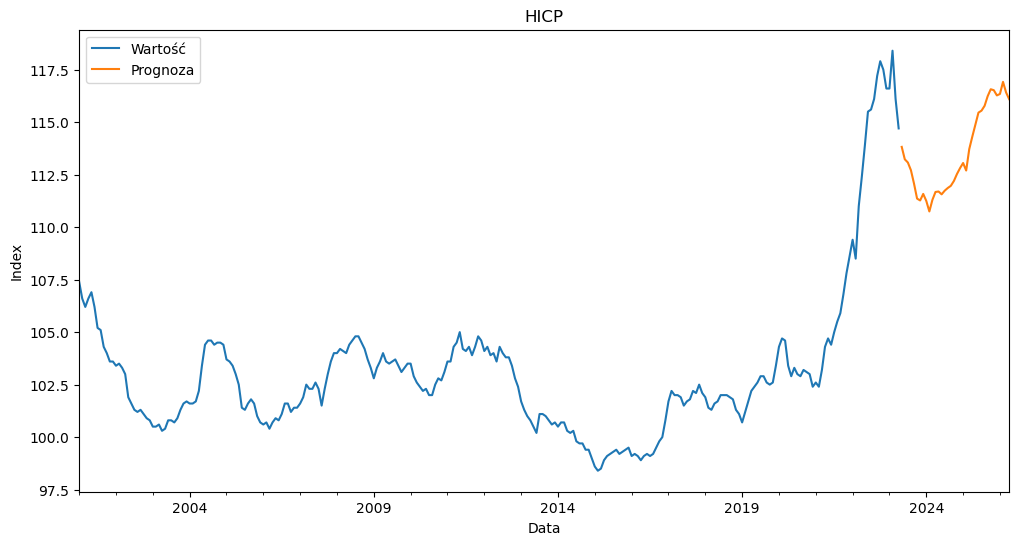

In [45]:
ax = data_m.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Prognoza')

plt.xlabel('Data')
plt.ylabel('Index')
plt.title("HICP")
plt.legend()
plt.show()

In [46]:
pred_ci.head(11)

,lower Wartość,upper Wartość
2023-05-01,112.990126,114.652501
2023-06-01,111.925700,114.533056
2023-07-01,111.328658,114.823537
2023-08-01,110.525121,114.893123
2023-09-01,109.455021,114.692329
2023-10-01,108.305314,114.410492
2023-11-01,107.784384,114.755720
2023-12-01,107.663876,115.498497
2024-01-01,106.901696,115.595338
2024-02-01,105.972949,115.520264


Text(0.5, 1.0, 'HICP')

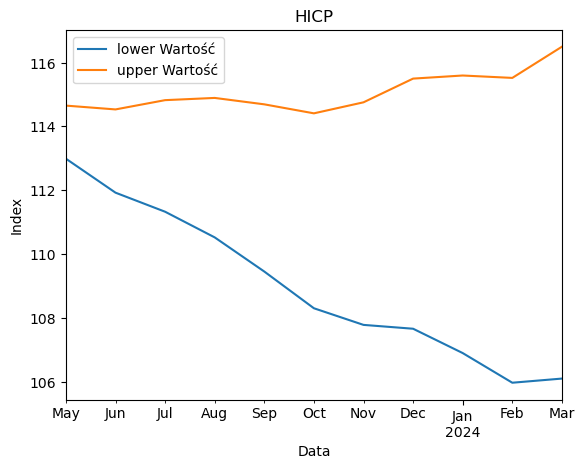

In [47]:
pred_ci.head(11).plot()
plt.xlabel('Data')
plt.ylabel('Index')
plt.title("HICP")

<b>Średnia z dolnego i górnego wyniku.</b>

In [48]:
pred_ci['Średnia'] = (pred_ci['lower Wartość'] + pred_ci['upper Wartość'])/2

In [49]:
pred_ci['Średnia'].head(11)

2023-05-01    113.821314
2023-06-01    113.229378
2023-07-01    113.076098
2023-08-01    112.709122
2023-09-01    112.073675
2023-10-01    111.357903
2023-11-01    111.270052
2023-12-01    111.581187
2024-01-01    111.248517
2024-02-01    110.746607
2024-03-01    111.299917
Freq: MS, Name: Średnia, dtype: float64

Text(0.5, 1.0, 'HICP')

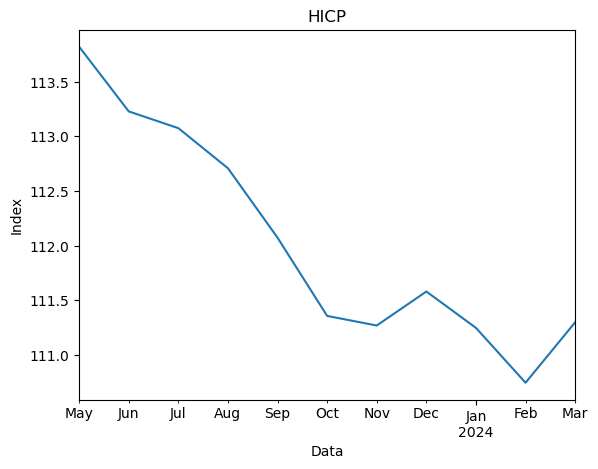

In [50]:
pred_ci['Średnia'].head(11).plot()
plt.xlabel('Data')
plt.ylabel('Index')
plt.title("HICP")

<h2>Wynik predykcji na miesiąc maj 2023: 13.82%</h2>

<h2>Rzeczywisty wynik na miesiąc maj 2023: 13.00%</h2>